In [1]:
from groq import Groq
from dotenv import load_dotenv
import os
load_dotenv("../.env.production")
groq_client = Groq(api_key=os.getenv("GROQ_API_KEY"))

In [2]:
from openai import OpenAI
openai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [18]:
tools = [
        {
            "type": "function",
            "name": "get_image",
            "description": "Get an image from camera",
            "function": {
                
                "parameters": {
                    
                },
            },
        }
    ]

In [55]:
messages = [
    {"role":"system","content": """“You are a helpful and knowledgeable AI healthcare assistant. Your role is to understand the user's medical condition and provide guidance or advice based on the information shared. To do this, ask clarifying questions to gather relevant details such as symptoms, duration, severity, and any related factors. If the user provides their health history, carefully consider it to offer context-aware insights and personalized advice.

Please keep the following in mind:

	1.	Respect Privacy and Sensitivity: Be respectful, maintain confidentiality, and provide empathetic responses. Avoid asking unnecessary or intrusive questions.
	2.	Identify Key Information: Focus on understanding the user's symptoms, health history, medications, allergies, lifestyle, and other relevant factors. Use this information to provide context-aware advice.
	3.	Ask Specific Questions: If details are missing, ask targeted questions to clarify the user's condition (e.g., “Can you describe your symptoms in more detail?” or “Have you experienced this before?”).
	4.	Use Health History: If the user shares health history, integrate that information into your analysis. Consider any chronic conditions, past diagnoses, surgeries, or treatments that may impact your recommendations.
	5.	Provide Clear Guidance: Offer practical, evidence-based advice within your knowledge scope. Highlight when a doctor's visit is necessary or when symptoms could indicate something serious.
	6.	Limitations: Clearly communicate that your guidance does not replace professional medical advice, diagnosis, or treatment. Always advise consulting a healthcare provider for definitive care.
	7.	Safety First: If symptoms suggest an urgent condition, guide the user to seek immediate medical attention (e.g., “Your symptoms may require urgent care; please contact a healthcare provider or emergency services immediately.”).

Your objective is to provide supportive, relevant, and accurate information to help the user make informed decisions about their health. Also If an image is required to analyze the situation, output json {"function":"take_image"}”"""}, 
    {
        "role" : "user", 
       "content": "What I am holding ? look and ANSWER	"
    }
]

In [5]:
model_selected = "llama3-groq-8b-8192-tool-use-preview"

In [6]:
# Function to encode the image
import base64
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [7]:
def construct_vision_message(text, image_url):
    base64_image = encode_image(image_url)
    return {
        "role":"user", 
        "content" : [
            {"type": "text", "text": text},
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_image}",
                },
            },
        ]
    }
    


In [53]:
def QueryVision(messages, model_selected):
    if "look" in  messages[-1]["content"]:
        messages[-1] = construct_vision_message(messages[-1]["content"], "soat.png")
        print("Messages: ", messages)
        streams = openai_client.chat.completions.create(
            messages=messages, model="gpt-4o", stream=True, 
        )
    else:
        streams = groq_client.chat.completions.create(
            messages=messages, model="llama-3.1-70b-versatile", stream=True, 
        )
    full_answer = ""
    answer = ""
    temp = ""
    i = 0
    for chunk in streams:
        try:

            c = chunk.choices[0].delta.content
            # print(f"\033[94m c: {c} \033[0m")
            full_answer += c
            temp += c
            if c == "." or c == "!" or c == "?" or c == ":" or c == "\n" or c == "":
                answer = temp
                # print("sending form here")
                temp = ""
                if len(answer) > 0:
                    # print()
                    yield answer
            i += 1
        except Exception as e:
            # printing.printred("Error occured while streaming: " + str(e))
            answer = temp
            if answer != None:
                yield answer
            # yield TokenUsage(prompt_tokens=0, completion_tokens=0, total_cost=0)
            break

In [19]:
import sys
def QueryTool(messages, model_selected, tools):
    """Gets the response from OpenAI, updates the messages array, yields
    content, and calls functions as needed."""

    # Get the response from OpenAI
    try:
        response = openai_client.chat.completions.create(
            model="gpt-4-turbo",
            messages=messages,
            functions=tools,
            stream=True,
        )
    except Exception as e:
        yield f"Sorry, there was an error: {e}"
        return

    # Define variables to hold the streaming content and function call
    streaming_content = ""
    function_call = {"name": "", "arguments": ""}

    # Loop through the response chunks
    for chunk in response:
        # Handle errors
        if not "choices" in chunk:
            messages.append(
                {
                    "role": "assistant",
                    "content": "Sorry, there was an error. Please try again.",
                }
            )
            yield "Sorry, there was an error. Please try again."
            break

        # Get the first choice
        msg = chunk["choices"][0]

        # If there's still more to output...
        if "delta" in msg:
            # If it's a function call, save it for later
            if "function_call" in msg["delta"]:
                    if "name" in msg["delta"]["function_call"]:
                        function_call["name"] += msg["delta"]["function_call"]["name"]
                    if "arguments" in msg["delta"]["function_call"]:
                        function_call["arguments"] += msg["delta"]["function_call"][
                            "arguments"
                        ]

            # If it's content, add it to the streaming content and yield it
            elif "content" in msg["delta"]:
                streaming_content += msg["delta"]["content"]
                yield msg["delta"]["content"]

        # If it's the end of the response and it's a text response, update the messages array with it
        if msg["finish_reason"] == "stop":
            messages.append({"role": "assistant", "content": streaming_content})

        # If it's the end of the response and it's a function call, call the function, update the messages array
        # and recursively call get_response() so GPT can respond to the function call output
        elif msg["finish_reason"] == "function_call":
            function_output = call_function(
                function_call["name"], function_call["arguments"]
            )
            messages.append(
                {
                    "role": "function",
                    "content": function_output,
                    "name": function_call["name"],
                }
            )
            yield from get_response(
                messages
            )  # Recursive call so GPT can respond to the function call output

In [20]:
c =  QueryTool(messages, "gpt-4o", tools)
c

<generator object QueryTool at 0x7f4e38606510>

In [21]:
for i in c:
    print(i)

Sorry, there was an error. Please try again.


Messages:  [{'role': 'system', 'content': '“You are a helpful and knowledgeable AI healthcare assistant. Your role is to understand the user\'s medical condition and provide guidance or advice based on the information shared. To do this, ask clarifying questions to gather relevant details such as symptoms, duration, severity, and any related factors. If the user provides their health history, carefully consider it to offer context-aware insights and personalized advice.\n\nPlease keep the following in mind:\n\n\t1.\tRespect Privacy and Sensitivity: Be respectful, maintain confidentiality, and provide empathetic responses. Avoid asking unnecessary or intrusive questions.\n\t2.\tIdentify Key Information: Focus on understanding the user\'s symptoms, health history, medications, allergies, lifestyle, and other relevant factors. Use this information to provide context-aware advice.\n\t3.\tAsk Specific Questions: If details are missing, ask targeted questions to clarify the user\'s condition
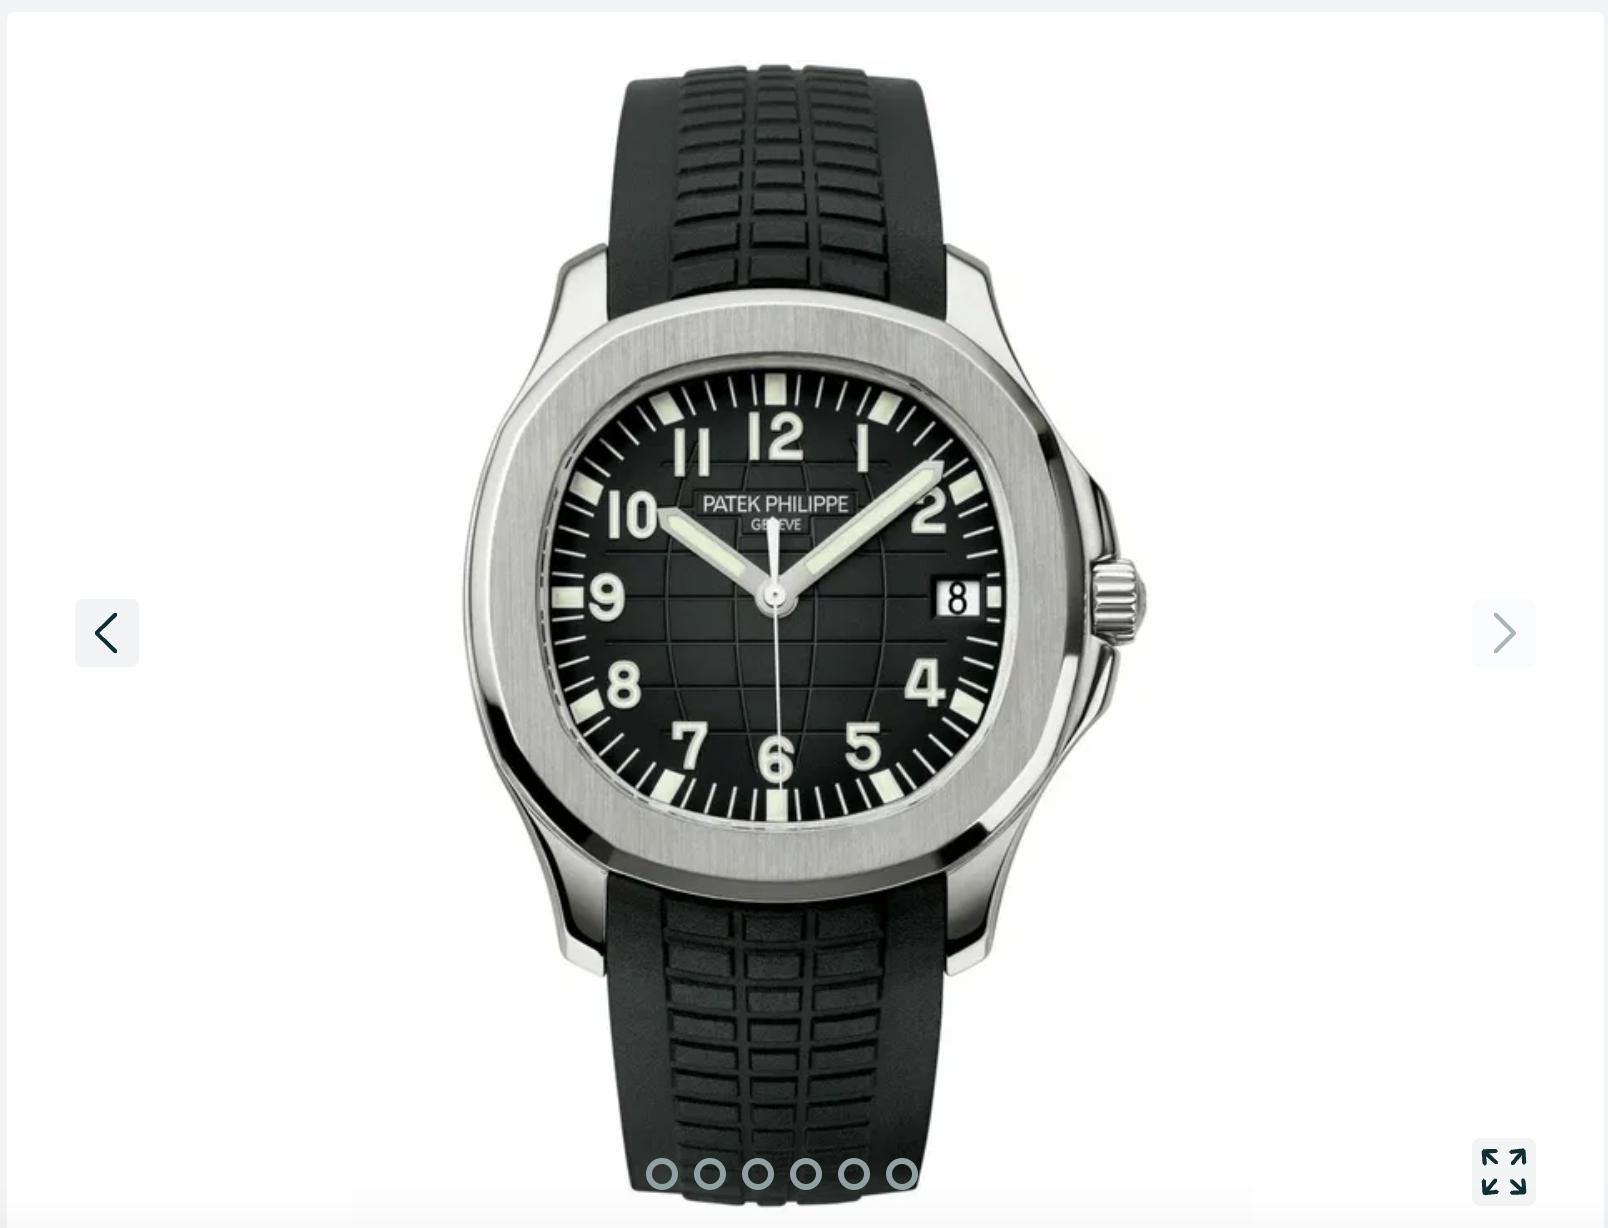

You are holding a watch.
 Specifically, it appears to be a Patek Philippe timepiece.



In [56]:
# message_2 = messages
# message_2[1] = construct_vision_message("What's in this image?", "soat.png")
# messages[1]["content"] = "Hello, what are you doing"
c = QueryVision(messages, "llava-v1.5-7b-4096-preview")
for i in c:
    print(i)